In [16]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.filters import median_filter
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

from tqdm import tqdm

In [2]:
# conv = vgg16.features[19].cuda()

# img_size = (1, 3, 224, 224)
# img = torch.rand(size=img_size, requires_grad=False).cuda()
# img = (img - 0.5) * 20 + 128

# random_img = Variable(img, requires_grad=True)
# random_img = random_img.cuda() if True else random_img

# out = conv(imgs[3]).cuda()
# loss = out[0, 3, :, :].mean().cuda()
# loss.backward()
# plt.imshow(out[0, 3].cpu().detach().numpy())
# conv.weight[0].shape

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [3]:
def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.
    # Arguments
        x: A numpy-array representing the generated image.
    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.25
    
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose(1, 2, 0)
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [4]:
def normalize(grad):
    norm_grad = torch.sqrt(
        (grad**2).mean()) + 1e-5
    return grad/norm_grad

In [193]:
def gradient_ascent(img, kernel_index, steps=20, learning_rate=1.0, 
                    conv=None, cuda=True):
    
    # Increasing the denoise frequency increases total
    # computation time but yields higher resolution images
    denoise_freq = int(steps/10)
    
    for step in range(steps):
        random_img = Variable(img, requires_grad=True)
        random_img = random_img.cuda() if cuda else random_img
        
        out = F.relu(conv(random_img)).cuda()
        out = out.cuda() if cuda else out
        
        loss = out[:, kernel_index, :, :].mean().cuda()
        loss = loss.cuda() if cuda else loss
        loss.backward()
        
        # Normilize gradients
        norm_grad = normalize(random_img.grad)
        
        img += norm_grad * lr
        
        if step%denoise_freq == 0:
            # Denoise image
            denoised_img = median_filter(img.cpu().numpy(), size=(1,3,3,3))
            denoised_img = torch.tensor(denoised_img)
            denoised_img = denoised_img.cuda() if cuda else denoised_img
            img *= 0 
            img += denoised_img
            
        if loss.item() <= 1e-07:
            return img, loss.item()
    
    return img.detach(), loss.item()

In [228]:
def get_image_kernel(img, conv=None, cuda=True):
    
    costs = []
    
    # Move the image to the GPU if possible
    _image = img.cuda() if cuda else img.cpu()
    
    # Pass the image trhough the network and compute the 
    # activation for each kernel; ie: ReLU, Sigmoid, etc...
    out = F.relu(conv(_image)).squeeze(0)
    out = out.cuda() if cuda else out
    
    print(f"Analyzing {out.shape[0]} kernels.")

    for kernel in tqdm(out):
        # get the mean activation value for each kernel
        loss = kernel.mean().cpu()
        costs.append(loss.item())

    # cleanup
    if _image.is_cuda: _image.detach().cpu()
    if out.is_cuda: out.detach().cpu()  
    
    topk = torch.topk(torch.tensor(cost), k=1)
    kernel_index = topk.indices.item()
    
    print(costs)
        
    # Create a random image and add noise
    rimage = torch.rand(size=_image.size(), requires_grad=False).cuda()
    rimage = (rimage - 0.5) * 20 + 128
    
    # Gradient Ascent
    image_kernel, loss = gradient_ascent(rimage, kernel_index, steps=40, 
                                         learning_rate=0.75, conv=conv)
    image_kernel = image_kernel.detach().cpu().squeeze(0).numpy()
    
    return image_kernel, kernel_index, loss

In [6]:
def activate_kernel(img, kernel_index, conv=None, cuda=True):
    
    img = img.cuda() if cuda else img

    out = F.relu(conv(img)).cpu()
    img = img.cpu()
    kernel = out[:, kernel_index, :, :].cpu()
    loss = kernel.sum().cpu()
    
    torch.cuda.empty_cache()
        
    return kernel.detach().numpy(), loss.item()

In [7]:
# data_path = '/media/gabriel/External 2.0 TB/ImageNet/1000_classes'
data_path = os.path.join(os.path.sep, 'media', 'gabriel', 
                         'External_2.0_TB', 'ImageNet', 
                         '1000_classes')
classes = next(os.walk(data_path, topdown=True))[1]
classes.sort()

len(classes)

977

In [8]:
tmp = torch.rand(size=(2,2))
tmp2 = Variable(tmp, requires_grad=True)
# tmp *= 0
# tmp += 1
tmp.numpy()

array([[0.76034606, 0.47574413],
       [0.99353534, 0.77531767]], dtype=float32)

In [9]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# Block 1
conv_1_1 = vgg16.features[0:2]
conv_1_2 = vgg16.features[:5]

# Block 2
conv_2_1 = vgg16.features[:7]
conv_2_2 = vgg16.features[:10]

# Block 3
conv_3_1 = vgg16.features[:12]
conv_3_2 = vgg16.features[:14]
conv_3_3 = vgg16.features[:17]

# Block 4
conv_4_1 = vgg16.features[:19]
conv_4_2 = vgg16.features[:21]
conv_4_3 = vgg16.features[:24]

# Block 5
conv_5_1 = vgg16.features[:26]
conv_5_2 = vgg16.features[:28]
conv_5_3 = vgg16.features[:31]

conv_2_1

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
)

In [12]:
imagenet_dataset = datasets.ImageFolder(
        data_path, 
        transform=transforms.Compose([
#             transforms.RandomCrop(deprocess_image),
            transforms.Resize(224),
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)            
        ]))
dataloader = DataLoader(
        imagenet_dataset, batch_size=5,
        shuffle=True, num_workers=4)

dataloader_iter = iter(dataloader)

In [13]:
images, labels = next(dataloader_iter)
image = images[0].numpy().transpose(1,2,0)
label = labels[0].item()

print(images.shape)
print(labels.shape)

torch.Size([5, 3, 224, 224])
torch.Size([5])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class:pigeon, Value:674


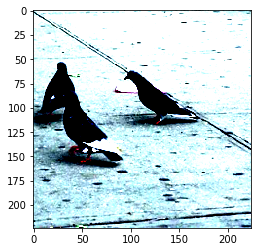

In [14]:
print('Class:%s, ' % classes[label] + 'Value:%s' % label)
plt.imshow(image)
plt.show()

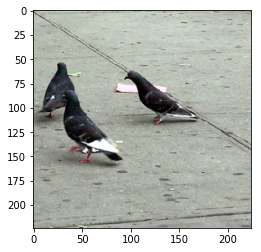

In [15]:
# Original image
_image = image * std
_image += mean
_image  = np.clip(_image, 0, 1)
_image *= 255
_image = _image.astype(np.uint8)

plt.imshow(_image)
plt.show()

In [194]:
lr = 1.0
kernel_index = 10

conv = conv_5_3.cuda()
num_of_kernels = conv[-3].weight.shape[0]

img_size = (1, 3, 224, 224)

kernels = []
costs = []

print(f"Performing gradient ascent on {num_of_kernels} kernels")

for kernel_index in tqdm(range(num_of_kernels)):
    # Create a random image
    img = torch.rand(size=img_size, 
                     requires_grad=False).cuda()
    # Add noise to the image
    img = (img - 0.5) * 20 + 128
    
    # Gradient Ascent
    img, loss = gradient_ascent(img, kernel_index, steps=40, 
                                learning_rate=0.75, conv=conv)
    
    if img is not None:
        kernels.append(img)
        costs.append([kernel_index, loss])
    
#     print( f'Filter: {kernel_index},' + f' Loss: {loss:.4f} ')
#     print(f'img.average(): {norm_grad.mean():.5}')

  0%|          | 2/512 [00:00<00:41, 12.34it/s]

Performing gradient ascent on 512 kernels


100%|██████████| 512/512 [01:34<00:00,  5.43it/s]


In [143]:
# conv_5_3

# Show top-10 Filters

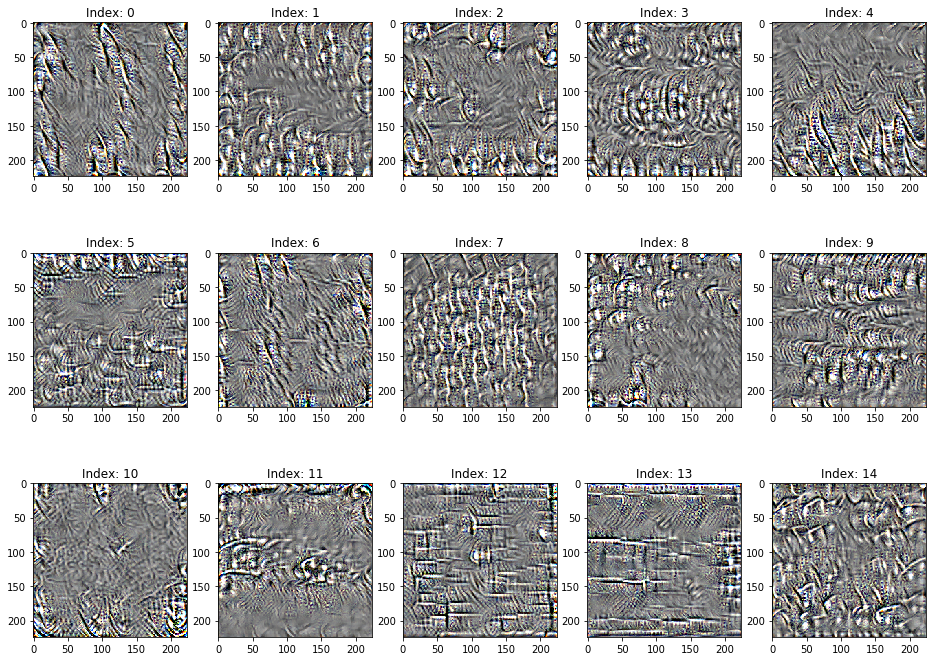

In [196]:
costs.sort(key=lambda x:x[1], reverse=True)

cols = 5
rows = 3
figsize = (16, 12) # width, height

fig, axs = plt.subplots(rows, cols, squeeze=False, figsize=figsize)
axs = axs.flatten()

for index, ax in enumerate(axs):
    kernel_index = costs[index][0] 
    kernel = kernels[kernel_index].cpu().detach().numpy()[0]
    kernel = deprocess_image(kernel)
#     print(kernel)
    kernel = np.clip(kernel, 0, 255).astype('uint8')
    ax.set_title("Index: %s" % (index))
    ax.imshow(kernel)

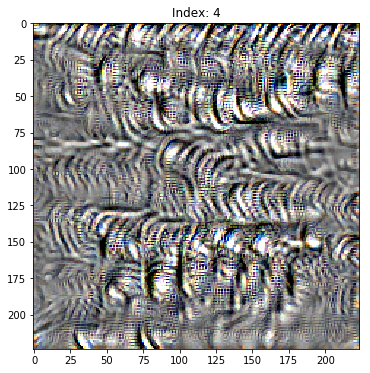

In [198]:
cols = 1
rows = 1
figsize = (6, 6) # width, height

fig, ax = plt.subplots(rows, cols, squeeze=False, figsize=figsize)
ax = ax.flatten()

index = costs[9][0] 

kernel = kernels[index].cpu().detach().numpy()[0]
kernel = deprocess_image(kernel)
ax[0].set_title("Index: %s" % 4)
ax[0].imshow(kernel)
plt.show()

In [236]:
costs[:10]

[[91, 708.505859375],
 [215, 604.0216064453125],
 [280, 513.6771850585938],
 [11, 310.6089782714844],
 [471, 273.8575439453125],
 [148, 270.3563537597656],
 [236, 266.7959289550781],
 [355, 258.1448974609375],
 [403, 244.27806091308594],
 [348, 228.67236328125]]

In [147]:
costs[:10]

[[91, 1156.9556884765625],
 [215, 1069.6094970703125],
 [280, 838.5459594726562],
 [403, 558.9613037109375],
 [471, 558.3931274414062],
 [11, 497.3310546875],
 [131, 476.9164123535156],
 [236, 474.9450988769531],
 [404, 464.5691223144531],
 [148, 458.7469177246094]]

# Display filters with highest activation

In [60]:
"""
Now we will pass an image for a particular class and visualize the kernels that 
provides the highest activation for images of that class
"""
lr = 1.0
kernel_index = 10

conv = conv_5_1.cuda()
num_of_kernels = conv[-2].weight.shape[0]

# img_size = (1, 3, 224, 224)
_image = images[0].unsqueeze(dim=0)

# Store metadata
kernels = []
costs = []

for kernel_index in range(num_of_kernels):
    kernel, cost = activate_kernel(_image, kernel_index, conv)
    kernels.append(kernel)
    costs.append(cost)

torch.cuda.empty_cache()

In [67]:
topk = torch.topk(torch.Tensor(costs), k=5)
topk

torch.return_types.topk(
values=tensor([825.9060, 723.9825, 718.6183, 688.6404, 649.6672]),
indices=tensor([425, 129, 478, 230,  97]))

In [56]:
kernel_index = topk.indices[0]
kernel = kernels[kernel_index]
cost = costs[kernel_index]

In [58]:
kernel.shape

(1, 14, 14)

In [230]:
def get_image_kernel(img, conv=None, cuda=True):
    
    costs = []
    
    # Move the image to the GPU if possible
    _image = img.cuda() if cuda else img.cpu()
    
    # Pass the image trhough the network and compute the 
    # activation for each kernel; ie: ReLU, Sigmoid, etc...
    out = F.relu(conv(_image)).squeeze(0)
    out = out.cuda() if cuda else out
    
    print(f"Analyzing {out.shape[0]} kernels.")

    for kernel in tqdm(out):
        # get the mean activation value for each kernel
        loss = kernel.mean().cpu()
        costs.append(loss.item())

    # cleanup
    if _image.is_cuda: _image.detach().cpu()
    if out.is_cuda: out.detach().cpu()  
    
    topk = torch.topk(torch.tensor(costs), k=1)
    kernel_index = topk.indices.item()
    
    print(topk)
        
    # Create a random image and add noise
    rimage = torch.rand(size=_image.size(), requires_grad=False).cuda()
    rimage = (rimage - 0.5) * 20 + 128
    
    # Gradient Ascent
    image_kernel, loss = gradient_ascent(rimage, kernel_index, steps=40, 
                                         learning_rate=0.75, conv=conv)
    image_kernel = image_kernel.detach().cpu().squeeze(0).numpy()
    
    return image_kernel, kernel_index, loss

In [253]:
pigeon_image = images[0].unsqueeze(0)
kernel, index, loss = get_image_kernel(pigeon_image, 
                                       conv_5_1, 
                                       cuda=True)

100%|██████████| 512/512 [00:00<00:00, 20810.16it/s]

Analyzing 512 kernels.
torch.return_types.topk(
values=tensor([4.2138]),
indices=tensor([425]))


In [256]:
index, loss

(425, 0.0)

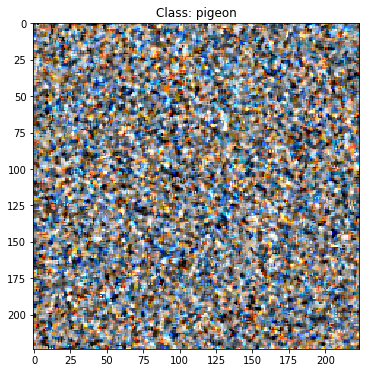

In [257]:
cols = 1
rows = 1
figsize = (6, 6) # width, height

fig, ax = plt.subplots(rows, cols, squeeze=False, figsize=figsize)
ax = ax.flatten()

_kernel = deprocess_image(kernel)
ax[0].set_title(f"Class: {classes[labels[0].item()]}")
ax[0].imshow(_kernel)
plt.show()

In [261]:
np.array(classes)[labels.numpy()]

array(['pigeon', 'foxglove', 'cricket', 'roller skating', 'sweater'],
      dtype='<U25')